See notebook in Google Colab : https://colab.research.google.com/drive/1JNaNhxlx_neYByuoS0BeYc87O1LsMQPQ?usp=sharing

In [ ]:
from google.colab import files

# Imports

In [ ]:
import numpy as np
from scipy.stats import norm, poisson
import pandas as pd
import matplotlib.pyplot as plt
from random import gauss
import math

# Variable initalizations

In [ ]:
phi = 0.1 # Continuous guarantee fees
G = gauss(0.0, 1.0) # Gaussian ? Value
T = 25 # Contract term
t = list(range(0,T,1)) # Policy anniversary dates
r = 0.04 # Interest rate
sigma = 0.15 # Volatility
P = 10000. # Single premium amount
s = 0.05 # Surrender fee
x0 = 40 # Age of the insured
A0 = P # Account Value

W0 = 0. # Cumulative withdrawals
D0 = 0. # Value of the death benefits
B0 = 1. # Bank account
S0 = 1. # Mutual fund of the variable annuity
xw = 1. # Portion of the premium that can be withdrawn annually ? Value

GD = A0 # GMDB = Guaranteed Minimum Death Benefits
GA = A0 # GMAB = Guaranteed Benefits
GI = A0 # GMIB
GW = A0 # GMWB = Remaining total amount that can be withdrawn annually
GE = xw*A0 # GMWB : Maximum amount that can be withdrawn annually
At = A0
Wt = W0
Dt = D0

step_up_factor = 0.
withdrawal_counts = 0

a_current = 1 # Annuitization factors
a_guar = 1

# Variables to initialize
already_dead=False
plot_Bt = []
plot_St = []
plot_At = []

# Options to choose

In [ ]:
GMDB = True
GMIB = False
GMAB = False
GMWB = False
roll_up = False
ratchet = False
step_up = False

# Main code

In [ ]:
for i in range(len(t)) :

  # Update plots
  plot_At.append(At)

  # Random happenings :
  if not already_dead :
    death = False if np.random.random() < 0.99 else True
  if death :
    already_dead = True
  withdrawal = False if np.random.random() < 0.7 else True
  if withdrawal :
    Et = np.random.random()*At # The insured withdraw an amount between 0 and the total amount At.
  surrender = False if np.random.random() < 0.5 else True

  #
  # Computing :
  Bt = B0*np.exp(r*t[i])
  St = S0*np.exp((r-1/2*sigma**2)*t[i] + sigma*G)
  At = At*np.exp(r-phi-1/2*sigma**2 + sigma*G)
  
  if i < len(t)-1 : # Before maturity

    # Between t+ and (t+1)-

    # A_(t+1)- = A_t+ * (S_t+1/S_t) * np.exp(-phi)
    # W_(t+1)- = W_t+ * np.exp(int^(t+1)_t (r) )
    # D_(t+1)- = D_t+ * np.exp(int^(t+1)_t (r) )
    # If guarantee benefit is a single premium or ratchet (it is adjusted after possible withdrawals):
      # GD_(t+1)- = GD_t+ or GA_(t+1)- = GA_t+ or GI_(t+1)- = GI_t+
    # If roll-up (roll-up rate i) :
      # GD_(t+1)- = GD_t+(1+i) or GA_(t+1)- = GA_t+(1+i) or GI_(t+1)- = GI_t+(1+i)
    # GW_(t+1)- = GW_t+ and GE_(t+1)- = GE_t+

    Wt = Wt*np.exp(r*(t[i+1] - t[i]))
    Dt = Dt*np.exp(r*(t[i+1] - t[i]))
    if roll_up :
      if GMDB :
        GD = GD*(1+roll_up)
      if GMIB :
        GI = GI*(1+roll_up)
      if GMAB :
        GA = GA*(1+roll_up)
    
    # Between (t+1)- and (t+1)+

  # a) If the insured dies in (t, t+1], we consider a death at t+1 : 
    # We credit the death benefit to the death benefit account and the we compound it with the risk free rate until maturity T : D_(t+1)+ = D_(t+1)- + max(GD_(t+1)-, A_(t+1)-)
    # No future benefits are possible so A_(t+1)+ = 0 and GA_(t+1)+ = GI_(t+1)+ = GW_(t+1)+ = GD_(t+1)+ = GE_(t+1)+ = 0
    # The withdrawal account does not change : W_(t+1)+ = W_(t+1)-

    if death : 
      Dt = Dt + max(GD, At)
      At, GA, GI, GW, GD, GE = 0, 0, 0, 0, 0, 0
      withdrawal_counts += 1
    else :

      # b) If the insured survives the year (t,t+1] and there are no withdrawal and no surrender at t+1 : 
        # D and W does not change : A_(t+1)+ = A_(t+1)-, D_(t+1)+ = D_(t+1)-, W_(t+1)+ = W_(t+1)-
          # with no ratchet guarantee : GA_(t+1)+ = GA_(t+1)- or GI_(t+1)+ = GI_(t+1)- or GD_(t+1)+ = GD_(t+1)-
          # if ratchet on A, I or D respectively : GA_(t+1)+ = max(GA_(t+1)-, A_(t+1)+) or GI_(t+1)+ = max(GI_(t+1)-, A_(t+1)+) or GD_(t+1)+ = max(GD_(t+1)-, A_(t+1)+)
        # if GMWB option with step-up and t+1 is a step-up point : 
          # if there is no past withdrawals : we denote by i_(w_(t+1)) the factor by which the total amount to be withdrawn is increased.
          # We update by GW_(t+1)+ = GW_(t+1)- * (1 + 1|_{W_(t+1)-=0}*i_(w_(t+1))) and GE_(t+1)+ = xw*GW_(t+1)+
          # Otherwise, GW_(t+1)+ = GW_(t+1)- and GE_(t+1)+ = GE_(t+1)-

      if not surrender and not withdrawal :
        if ratchet :
          if GMDB :
            GD = max(GD,At)
          if GMIB :
            GI = max(GI,At)
          if GMAB :
            GA = max(GA,At)
        if step_up and withdrawal_counts == 0 :
          if GMWB :
            if Wt == 0 :
              GW = GW * (1+step_up_factor)
            GE = xw*GW
      
      # c) The insured survives the year (t,t+1] and withdraws an amount WITHIN the limits of the GMWB option
        # The withdrawn E_(t+1) may neither exceed the maximal annual withdrawal amount GE_(t+1)- nor the remaining total withdrawal amount GW_(t+1)-
        # A_(t+1)+ = max(0,A_(t+1)- - E_(t+1))
        # GW_(t+1)+ = GW_(t+1)- - E_(t+1)
        # W_(t+1)+ = W_(t+1)- - E_(t+1)
        # Pro rata adjustment : 
          # With no ratchet : GA_(t+1)+ = (A_(t+1)+/A_(t+1)-)*GA_(t+1)- or GI_(t+1)+ = (A_(t+1)+/A_(t+1)-)*GI_(t+1)- or GD_(t+1)+ = (A_(t+1)+/A_(t+1)-)*GD_(t+1)-
          # If ratchet : GA_(t+1)+ = max(A_(t+1)+,(A_(t+1)+/A_(t+1)-)*GA_(t+1)-) or GI_(t+1)+ = max(A_(t+1)+,(A_(t+1)+/A_(t+1)-)*GI_(t+1)-) or GD_(t+1)+ = max(A_(t+1)+,(A_(t+1)+/A_(t+1)-)*GD_(t+1)-)

      if withdrawal and not surrender and Et <= min(GE,GW): # c) If the insured survives the year (t,t+1] and withdraws an amount within the limits of the GMWB option
        past_At = At
        At = max(0,At-Et)
        GW = GW - Et
        Wt = Wt + Et
        if ratchet :
          if GMDB :
            GD = (At/past_At) * GD
          if GMIB :
            GI = (At/past_At) * GI
          if GMAB :
            GA = (At/past_At) * GA
        else :
          if GMDB :
            GD = max(At,(At/past_At) * GD)
          if GMIB :
            GI = max(At,(At/past_At) * GI)
          if GMAB :
            GA = max(At,(At/past_At) * GA)

      # d)The insured survives the year (t,t+1] and withdraws an amount exceeding the limits of the GMWB option
        # d1) The contract does not comprise a GMWB option and an amount 0 < E_(t+1) < A_(t+1)-
        # d2) A GMWB option is included in the contract, but the insured withdraws an amount 0 < E_(t+1) < A_(t+1)- with E_(t+1) > min(GE_(t+1)-, GW_(t+1)-)
        # d3) The insured surrenders by withdrawing the amount E_(t+1) = A_(t+1)-

      if withdrawal and Et > min(GE,GW):
        Et1 = min(GE, GW)
        Et2 = Et - Et1
        past_At = At
        At = At-Et
        if surrender :
          Wt = Wt + Et1 + Et2*(1-s) # surrender fee
        if ratchet :
          if GMDB :
            GD = (At/past_At) * GD
          if GMIB :
            GI = (At/past_At) * GI
          if GMAB :
            GA = (At/past_At) * GA
        else :
          if GMDB :
            GD = max(At,(At/past_At) * GD)
          if GMIB :
            GI = max(At,(At/past_At) * GI)
          if GMAB :
            GA = max(At,(At/past_At) * GA)
        if GMWB :
          GW = min(GW - Et, GW * (At/past_At))
          GE = GE * (At/past_At)

  else : # At maturity T

      if not GMIB and not GMAB :
        LT = At
      else :
        if GMAB :
          LAT = max(At, GA)
        if GMIB :
          LIT = max(At, GI * a_current/a_guar)
        if GMAB and GMIB :
          LT = max(LAT, LIT)
        else :
          LT = LAT if GMAB else LIT

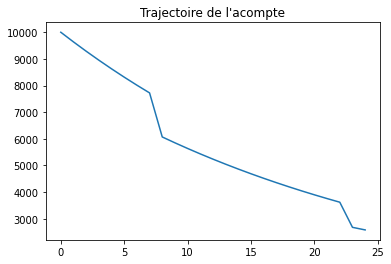

In [ ]:
plt.figure("Trajectoire de l'acompte")
plt.title("Trajectoire de l'acompte")
plt.plot(plot_At)
plt.savefig("Trajectoire de l'acompte.svg")

In [ ]:
#files.download('Trajectoire de l\'acompte.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>